## Importing necessary Libraries

In [1]:
!pip install hazm
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
from hazm import Normalizer, word_tokenize
import pandas as pd
import numpy as np
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
from transformers import AutoConfig, AutoTokenizer,AutoModel
from transformers.models.longformer import LongformerForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


## Importing Dataset and DataCleaning Step

#### Importing ParsTail

Importing The PARSTail DATASET from github

In [3]:
url_train = 'https://raw.githubusercontent.com/dml-qom/FarsTail/master/data/Train-word.csv'
url_test = 'https://raw.githubusercontent.com/dml-qom/FarsTail/master/data/Test-word.csv'
url_validation = 'https://raw.githubusercontent.com/dml-qom/FarsTail/master/data/Val-word.csv'

train_data  = pd.read_csv(url_train, sep='\t')
test_data  = pd.read_csv(url_test, sep='\t')
validation_data  = pd.read_csv(url_validation, sep='\t')


#### Analyse The Dataset

Plotting the Train data distribution on differenct groups of labels

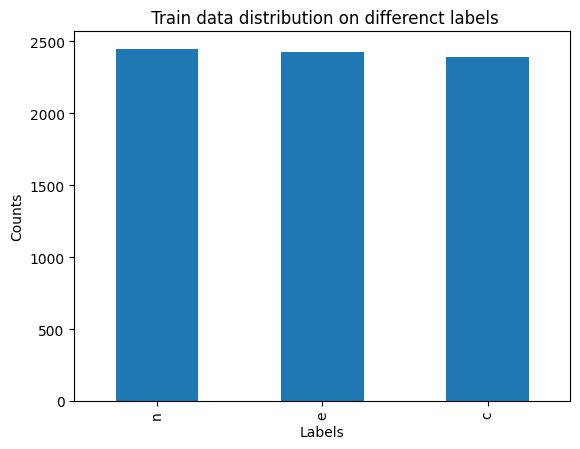

In [4]:
train_data['label'].value_counts().plot(kind='bar',title = " Train data distribution on differenct labels")
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

Plotting the test data distribution on differenct groups of labels

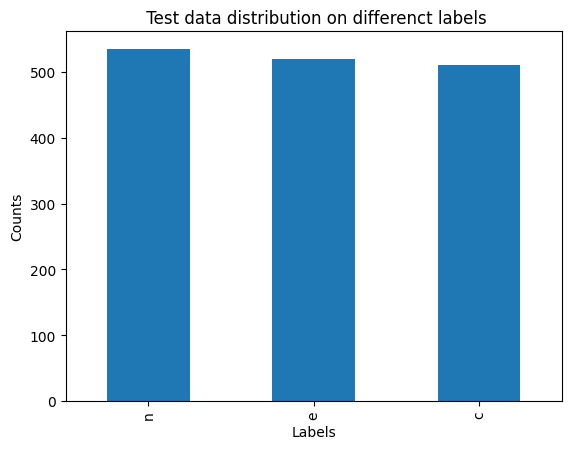

In [5]:
test_data['label'].value_counts().plot(kind='bar',title = " Test data distribution on differenct labels")
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()


Plotting the validation data distribution on differenct groups of labels

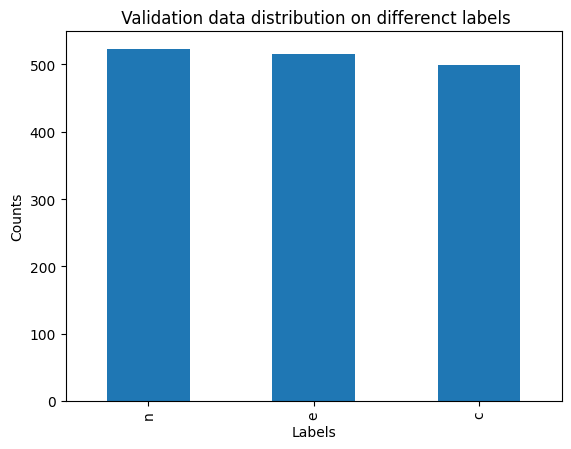

In [6]:
validation_data['label'].value_counts().plot(kind='bar',title = " Validation data distribution on differenct labels")
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()


#### Doing The PreProcessing On the dataset

In [7]:
def clean_html(s):
    return re.sub(re.compile('<.*?>'), '', s)

normalizer = Normalizer()    
def preprocessing(s):
  s = s.strip()
  
  s = clean_html(s)


  s = normalizer.normalize(s)

  extra_characters = re.compile("["
    u"\U0001F600-\U0001F64F"  
    u"\U0001F300-\U0001F5FF"  
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)

  s = extra_characters.sub(r'', s)
  s = re.sub("\s+", " ", s)         # trailing whitespace
  s = re.sub(r'(@.*?)[\s]', ' ', s) # @ mentions
  s = re.sub("#|\-", "", s)            # hashtags

  return s

In [8]:
train_data['premise'] = train_data['premise'].apply(preprocessing)
test_data['premise'] = test_data['premise'].apply(preprocessing)
validation_data['premise'] = validation_data['premise'].apply(preprocessing)


train_data['hypothesis'] = train_data['hypothesis'].apply(preprocessing)
validation_data['hypothesis'] = validation_data['hypothesis'].apply(preprocessing)
test_data['hypothesis'] = test_data['hypothesis'].apply(preprocessing)

Here we use labelencoder to turn categorical labels into numbers

In [9]:
train_data['label'] = LabelEncoder().fit_transform(train_data['label'])
validation_data['label'] = LabelEncoder().fit_transform(validation_data['label'])
test_data['label'] = LabelEncoder().fit_transform(test_data['label'])

## Defining Universal functions : 

Functions Like evaluate_model acuuracy train and others are defined here.

In [10]:
## Function for evaluation the model after train(finetune)
def evaluate_model(model, test_dataloader):
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loop = tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader))
    with torch.no_grad():
        all_labels = []
        all_preds = []
        for batch, dl in test_loop:
            input_ids = dl['input_ids'].to(device)
            token_type_ids = dl['token_type_ids'].to(device)
            attention_mask = dl['attention_mask'].to(device)
            label1 = dl['target'].to(device)
            label1 = label1.unsqueeze(1)

            output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            label1 = label1.squeeze()
            label = pd.get_dummies(label1.cpu())
            label = torch.from_numpy(label.values)
            label = label.to(device)
            label = label.type_as(output)

            pred = torch.argmax(output, dim=1)
            label1 = label1.cpu().numpy()
            pred = pred.cpu().numpy()

            all_labels.extend(label1)
            all_preds.extend(pred)
    return all_labels, all_preds


# Function to caluculate the metrics asked in the question
def calculate_metrics(labels, preds):
    cm = confusion_matrix(labels, preds)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return cm, accuracy, precision, recall, f1

# Function to plot the confusion matrix for each step
def plot_confusion_matrix(cm, classes,task):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True,  fmt='d', xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.savefig('Confusion_Matrix_' + task + '.png')
    plt.show()

# compute accuracy at each step
def compute_accuracy(pred, label1):
    num_correct = torch.sum(pred == label1).item()
    num_samples = pred.shape[0]
    accuracy = num_correct / num_samples
    return accuracy

# function to calculate loss
def calculate_loss(output, label, loss_fn):
    loss = loss_fn(output, label)
    return loss

def average(lst):
    return sum(lst) / len(lst)


# Plotting the Loss and also accuracy at each epoch
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, name_plot):
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig('loss_acc_plot_' + name_plot + '.png')

def train(epochs, dataloader, valid_dataloader, model, loss_fn, optimizer, name_plot):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        loss_his = []
        acc_his = []
        print(f"Epoch {epoch+1}/{epochs}")
        model.to(device)
        model.train()
        loop = tqdm(enumerate(dataloader), leave=False, total=len(dataloader))
        for batch, dl in loop:
            input_ids = dl['input_ids'].to(device)
            token_type_ids = dl['token_type_ids'].to(device)
            attention_mask = dl['attention_mask'].to(device)
            label1 = dl['target'].to(device)
            label1 = label1.unsqueeze(1)

            optimizer.zero_grad()

            output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            label1 = label1.squeeze()
            label = pd.get_dummies(label1.cpu())
            label = torch.from_numpy(label.values)
            label.to(device)
            label = label.type_as(output)

            loss = calculate_loss(output, label, loss_fn)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(output, dim=1)
            accuracy = compute_accuracy(pred, label1)

            loop.set_description(f'Epoch={epoch+1}/{epochs}')
            loop.set_postfix(loss=loss.item(), acc=accuracy)
            loss_his.append(loss.item())
            acc_his.append(accuracy)

        avg_train_loss = average(loss_his)
        avg_train_acc = average(acc_his)
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(avg_train_acc)

        model.eval()
        val_loss_his = []
        val_acc_his = []
        with torch.no_grad():
            val_loop = tqdm(enumerate(valid_dataloader), leave=False, total=len(valid_dataloader))
            for batch, dl in val_loop:
                input_ids = dl['input_ids'].to(device)
                token_type_ids = dl['token_type_ids'].to(device)
                attention_mask = dl['attention_mask'].to(device)
                label1 = dl['target'].to(device)
                label1 = label1.unsqueeze(1)

                optimizer.zero_grad()

                output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                label1 = label1.squeeze()
                label = pd.get_dummies(label1.cpu())
                label = torch.from_numpy(label.values)
                label.to(device)
                label = label.type_as(output)

                loss = calculate_loss(output, label, loss_fn)
                pred = torch.argmax(output, dim=1)
                accuracy = compute_accuracy(pred, label1)

                loop.set_description(f'Epoch={epoch}/{epochs}')
                loop.set_postfix(loss=loss.item(), acc=accuracy)

                val_loss_his.append(loss.item())
                val_acc_his.append(accuracy)

        avg_val_loss = average(val_loss_his)
        avg_val_acc = average(val_acc_his)
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(avg_val_acc)

        print(f'Train Loss is : {avg_train_loss:.3f} | Train Accuracy is : {avg_train_acc*100:.3f}%')

    plot_loss_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history, name_plot)

    return model


## **Part 1**

In this part ParsBERT is used as an embedding and a network is designed using a TransformerEncoder layer. The task at hand is to train this network.

also we freeze the parameters of the BERT model so that they are not updated during the training of the network.

Additionally, we will add to the output, the CLS token as the classification input.

#### Creating ParsBert Dataset 

This code prepares dataset (ParsBert_Dataset_pt) for training in form of Pytorch

In [ ]:
class ParsBert_Dataset_pt(Dataset):
    def __init__(self, data, tokenizer, max_length):
        super(ParsBert_Dataset_pt, self).__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.target = self.data.iloc[:, 2]  # Extracting the target values from the data
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)  # Returns the length of the dataset
    
    def __getitem__(self, index):
        # Encoding the input text using the tokenizer
        encoded_inputs = self.tokenizer.encode_plus(
            self.data.iloc[index, 0],  # First text input
            self.data.iloc[index, 1],  # Second text input
            pad_to_max_length=True,  # Padding the sequences to the max length
            add_special_tokens=True,  # Adding special tokens (e.g., [CLS], [SEP])
            return_attention_mask=True,  # Returning attention mask
            max_length=self.max_length,  # Maximum length of the input sequences
        )
        
        input_ids = encoded_inputs["input_ids"]  # Encoded input sequence IDs
        token_type_ids = encoded_inputs["token_type_ids"]  # Token type IDs (e.g., 0 for first sentence, 1 for second)
        attention_mask = encoded_inputs["attention_mask"]  # Attention mask
        
        target = self.data.iloc[index, 2]  # Target value for the input pair
        
        return {
            'ids': torch.tensor(input_ids, dtype=torch.long),  # Converting input_ids to a PyTorch tensor
            'mask': torch.tensor(attention_mask, dtype=torch.long),  # Converting attention_mask to a PyTorch tensor
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),  # Converting token_type_ids to a PyTorch tensor
            'target': torch.tensor(target, dtype=torch.long)  # Converting target to a PyTorch tensor
        }

In [ ]:
class ParsBert_task1(nn.Module):
    def __init__(self, config_layer, freeze, num_classes):
        super(ParsBert_task1, self).__init__()
        
        # Load the BERT model
        bert_model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", config=config_layer)
        
        # Freeze the BERT model if freeze is True
        if freeze:
            for param in bert_model.parameters():
                param.requires_grad = False  # Set requires_grad to False to freeze the parameters
        
        self.embedding = bert_model  # Use BERT model as the embedding layer
        
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=bert_model.config.hidden_size,  # Set the input size of the transformer layer to BERT's hidden size
            nhead=bert_model.config.num_attention_heads  # Set the number of attention heads in the transformer layer
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer=self.transformer_layer,  # Use the transformer layer defined above
            num_layers=1  # Set the number of transformer layers to 1
        )
        
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)  # Classifier layer
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        embeddings = self.embedding(input_ids, attention_mask, token_type_ids)[0]  # Get BERT embeddings
        encoded = self.transformer(embeddings)  # Apply transformer encoding
        pooled = encoded.mean(dim=1)  # Average pooling over the sequence length
        logits = self.classifier(pooled)  # Feed pooled representation to the classifier
        return logits


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

train_dataset = ParsBert_Dataset_pt(train_data,tokenizer, max_length=100)
train_dataloader=DataLoader(dataset=train_dataset,batch_size=128,drop_last= True)

validation_dataset = ParsBert_Dataset_pt(validation_data,tokenizer, max_length=100)
validation_dataloader= DataLoader(dataset=validation_dataset,batch_size=128,drop_last= True)

test_dataset = ParsBert_Dataset_pt(test_data,tokenizer, max_length=100)
test_dataloader= DataLoader(dataset=test_dataset,batch_size=128,drop_last= True)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/12


Train Loss is : 1.078 | Train Accuracy is : 40.904%
Epoch 2/12


Train Loss is : 1.012 | Train Accuracy is : 47.754%
Epoch 3/12


Train Loss is : 0.977 | Train Accuracy is : 51.367%
Epoch 4/12


Train Loss is : 0.946 | Train Accuracy is : 53.237%
Epoch 5/12


Train Loss is : 0.962 | Train Accuracy is : 51.646%
Epoch 6/12


Train Loss is : 0.906 | Train Accuracy is : 55.678%
Epoch 7/12


Train Loss is : 0.878 | Train Accuracy is : 57.966%
Epoch 8/12


Train Loss is : 0.876 | Train Accuracy is : 57.659%
Epoch 9/12


Train Loss is : 0.873 | Train Accuracy is : 57.924%
Epoch 10/12


Train Loss is : 0.898 | Train Accuracy is : 56.403%
Epoch 11/12


Train Loss is : 0.912 | Train Accuracy is : 55.650%
Epoch 12/12


Train Loss is : 0.903 | Train Accuracy is : 55.246%


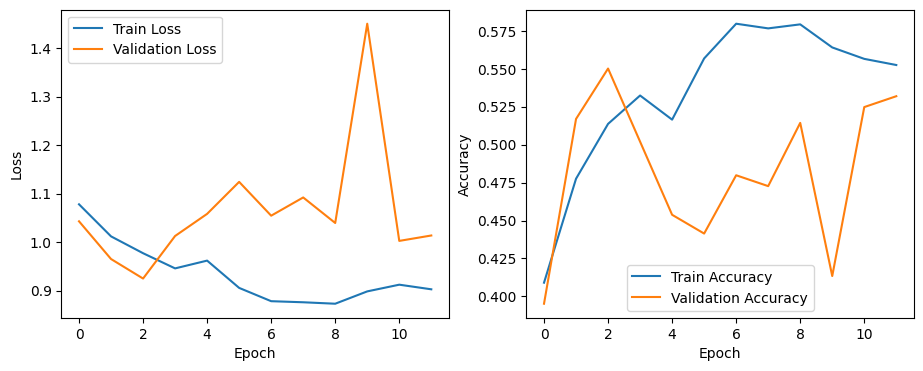

In [ ]:
epochs = 12
config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model=ParsBert_task1(config_layer,True,3)

optimizer= optim.Adam(model.parameters(),lr= 0.0001)

model_Task1 = train(epochs, dataloader=train_dataloader , valid_dataloader = validation_dataloader,
         model = model, loss_fn=nn.CrossEntropyLoss(),
         optimizer=optimizer,name_plot =  "Part1")


Test Accuracy for Task 1: 0.516
Test Precision for Task 1: 0.572
Test Recall for Task 1: 0.513
Test F1-score for Task 1: 0.468
Confusion Matrix for Task 1: 


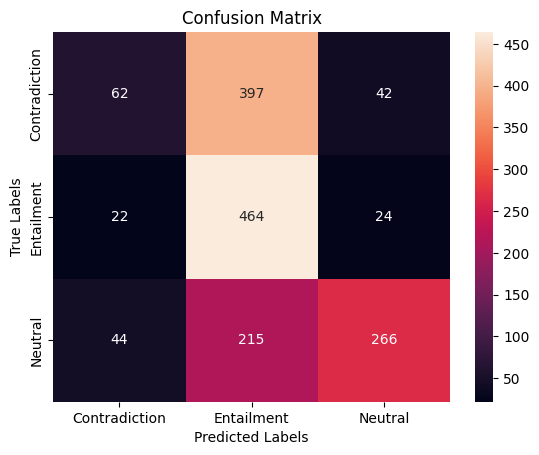

In [ ]:
# Evaluation
all_labels, all_preds = evaluate_model(model_Task1, test_dataloader)
cm, accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

print(f'Test Accuracy for Task 1: '  + str('{:.3f}'.format(accuracy) ) )
print(f'Test Precision for Task 1: ' + str('{:.3f}'.format(precision) ) )
print(f'Test Recall for Task 1: ' + str('{:.3f}'.format(recall) ) )
print(f'Test F1-score for Task 1: '+ str('{:.3f}'.format(f1) ) )
print('Confusion Matrix for Task 1: ')

# Plot Confusion Matrix
plot_confusion_matrix(cm, ['Contradiction', 'Entailment', 'Neutral'],'Task1')

## **Part 2**

In [15]:
class ParsBertDataset(Dataset):
    def __init__(self,data, tokenizer,max_length):
        super(ParsBertDataset, self).__init__()
        #self.root_dir=root_dir
        self.train_csv= data
        self.tokenizer=tokenizer
        self.target=self.train_csv.iloc[:,1]
        self.max_length=max_length
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        text1 = self.train_csv.iloc[index,0]
        text2 = self.train_csv.iloc[index,1]
        inputs = self.tokenizer.encode_plus(
            text1 ,
            text2,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        input_ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        attention_mask = inputs["attention_mask"]
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.train_csv.iloc[index, 2], dtype=torch.long)
            }


In [14]:

class Pars_BERT(nn.Module):
    def __init__(self, config_layers):
        super(Pars_BERT, self).__init__()
        self.bert_model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", config = config_layers)
        self.linear1 = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(256, 3)
        
    def forward(self,input_ids,attention_mask,token_type_ids):
        _,o2= self.bert_model(input_ids = input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids, return_dict=False)
        out= self.linear1(o2)
        out= self.relu(out)
        out = self.dropout(out)
        out= self.out(out)
        
        return out


In [16]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

train_dataset = ParsBertDataset(train_data,tokenizer, max_length=100)
train_dataloader=DataLoader(dataset=train_dataset,batch_size=128,drop_last= True)

validation_dataset = ParsBertDataset(validation_data,tokenizer, max_length=100)
validation_dataloader= DataLoader(dataset=validation_dataset,batch_size=128,drop_last= True)

test_dataset = ParsBertDataset(test_data,tokenizer, max_length=100)
test_dataloader= DataLoader(dataset=test_dataset,batch_size=128,drop_last= True)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/5


  0%|          | 0/56 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train Loss is : 0.793 | Train Accuracy is : 63.211%
Epoch 2/5


Train Loss is : 0.448 | Train Accuracy is : 82.785%
Epoch 3/5


Train Loss is : 0.321 | Train Accuracy is : 88.379%
Epoch 4/5


Train Loss is : 0.229 | Train Accuracy is : 92.285%
Epoch 5/5


Train Loss is : 0.171 | Train Accuracy is : 94.224%


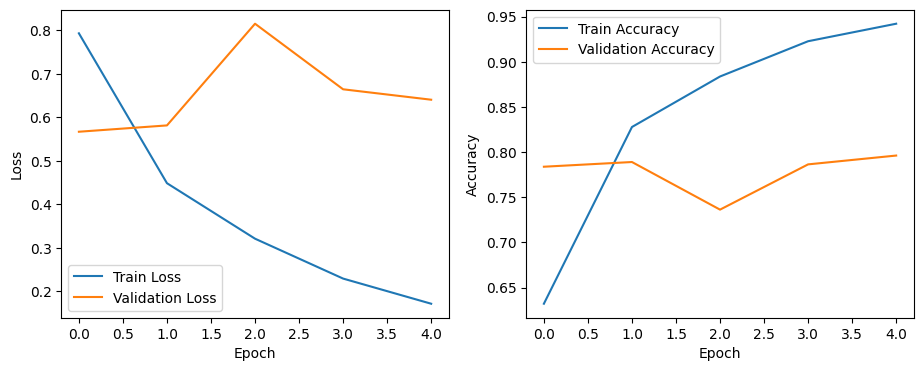

In [ ]:
model_task2=Pars_BERT(config_layers)

for param in model_task2.bert_model.parameters():
    param.requires_grad = True

model=train(epochs = 5, dataloader = train_dataloader,
               valid_dataloader = validation_dataloader, model=model_task2,
               loss_fn = nn.CrossEntropyLoss(),
               optimizer = optim.Adam(model_task2.parameters(),lr= 0.0001), 
               name_plot = "Task2")


Test Accuracy for Task 1: 0.809
Test Precision for Task 1: 0.809
Test Recall for Task 1: 0.807
Test F1-score for Task 1: 0.806
Confusion Matrix for Task 1: 


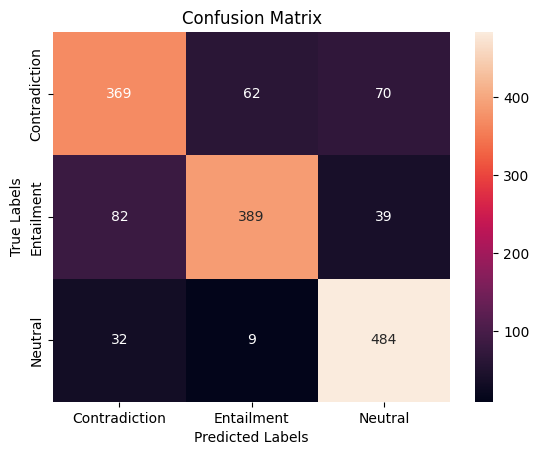

In [ ]:
all_labels, all_preds = evaluate_model(model_task2, test_dataloader)
cm, accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

print(f'Test Accuracy for Task 1: '  + str('{:.3f}'.format(accuracy) ) )
print(f'Test Precision for Task 1: ' + str('{:.3f}'.format(precision) ) )
print(f'Test Recall for Task 1: ' + str('{:.3f}'.format(recall) ) )
print(f'Test F1-score for Task 1: '+ str('{:.3f}'.format(f1) ) )
print('Confusion Matrix for Task 1: ')

plot_confusion_matrix(cm, ['Contradiction', 'Entailment', 'Neutral'],'Task2')

## **Part 3**

In [14]:
def train_task3(epochs, train_dataloader, valid_dataloader, model, loss_fn, optimizer,name_plot):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(epochs):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        train_loop = tqdm(enumerate(train_dataloader), leave=False, total=len(train_dataloader))
        for batch, dl in train_loop:
            input_ids = dl['input_ids'].to(device)
            token_type_ids = dl['token_type_ids'].to(device)
            attention_mask = dl['attention_mask'].to(device)
            label1 = dl['target'].to(device)
            label1 = label1.unsqueeze(1)
            
            optimizer.zero_grad()
            
            output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            label1 = label1.squeeze()
            label = pd.get_dummies(label1.cpu())
            label = torch.from_numpy(label.values)
            label.to(device)
            label = label.type_as(output)
            
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            
            pred = torch.argmax(output, dim=1)
            num_correct = torch.sum(pred == label1).item()
            num_samples = pred.shape[0]
            accuracy = num_correct / num_samples
            
            train_loop.set_description(f'Epoch {epoch+1}/{epochs}')
            train_loop.set_postfix(loss=loss.item(), acc=accuracy)
            
            train_loss.append(loss.item())
            train_acc.append(accuracy)
        
        train_loss_history.append(np.mean(train_loss))
        train_acc_history.append(np.mean(train_acc))
        
        # Validation
        labels, preds = evaluate_model(model, valid_dataloader)
        cm, accuracy, precision, recall, f1 = calculate_metrics(labels, preds)
        
        val_loss_history.append(np.mean(val_loss))
        val_acc_history.append(np.mean(val_acc))
        
        # Print and plot train/validation loss and accuracy
        print(f'Train Loss: {train_loss_history[-1]:.4f} | Train Acc: {train_acc_history[-1]*100:.2f}%')
        print(f'Val Loss: {val_loss_history[-1]:.4f} | Val Acc: {val_acc_history[-1]*100:.2f}%')
    
    # Plot train/validation loss and accuracy
    plot_loss_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history, name_plot)
    
    return model


In [18]:

def model_eval(model, test_dataloader, name_plot):
    labels, preds = evaluate_model(model, test_dataloader)
    cm,accuracy, precision, recall, f1,  = calculate_metrics(labels, preds)

    print(f'Test Accuracy: {accuracy*100:.2f}')
    print(f'Test Precision: {precision*100:.2f}')
    print(f'Test Recall: {recall*100:.2f}')
    print(f'Test F1-score: {f1*100:.2f}')
    print('Confusion Matrix:')
    print(cm)

    plot_confusion_matrix(cm, ['Contradiction', 'Entailment', 'Neutral'], name_plot)

    return accuracy, precision, recall, f1, cm


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loss_fn = nn.CrossEntropyLoss()
#Initialize Optimizer
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
cm_lst = []

number_of_layers: 11


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.11.output.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.11.intermediate.dense.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.11.output.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.11.attention.self.key.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.11.attention.output.dense.bias', 'bert.encoder.layer.11.attent

Epoch 1/5


Train Loss: 0.8127 | Train Acc: 60.52%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.4945 | Train Acc: 80.30%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.3210 | Train Acc: 87.96%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.2068 | Train Acc: 92.51%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.1602 | Train Acc: 94.29%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 80.14
Test Precision: 80.70
Test Recall: 79.90
Test F1-score: 79.35
Confusion Matrix:
[[299  94 108]
 [ 31 444  35]
 [ 27  10 488]]


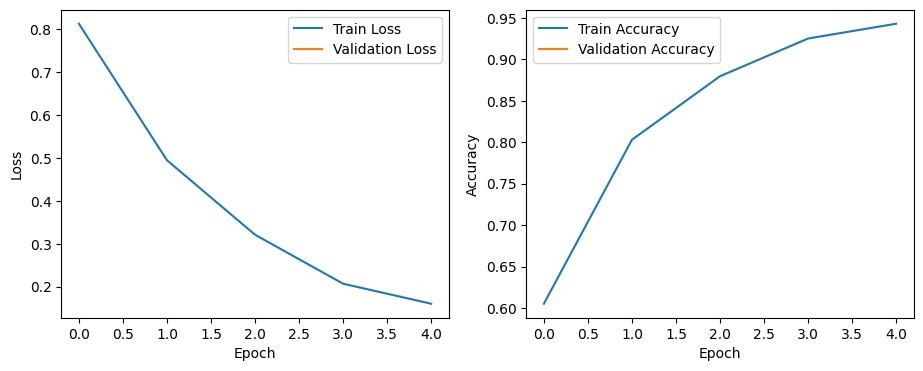

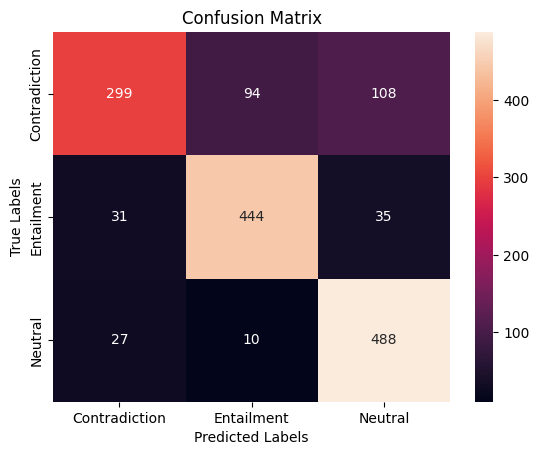

number_of_layers: 10


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.11.output.dense.bias', 'bert.encoder.layer.10.attention.self.value.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.10.attention.self.query.weight', 'bert.encoder.layer.11.intermediate.dense.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.11.output.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.weight', 'bert.encoder.layer.10.output.LayerNorm.bias', 'bert.encoder.layer.10.output.dense.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.bias', 'bert.encoder.layer.10.attention.ou

Epoch 1/5


Train Loss: 0.8158 | Train Acc: 62.68%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.4958 | Train Acc: 80.82%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.3274 | Train Acc: 87.81%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.2228 | Train Acc: 92.31%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.1906 | Train Acc: 93.35%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 78.97
Test Precision: 78.93
Test Recall: 78.81
Test F1-score: 78.70
Confusion Matrix:
[[352  67  82]
 [ 93 385  32]
 [ 41   8 476]]


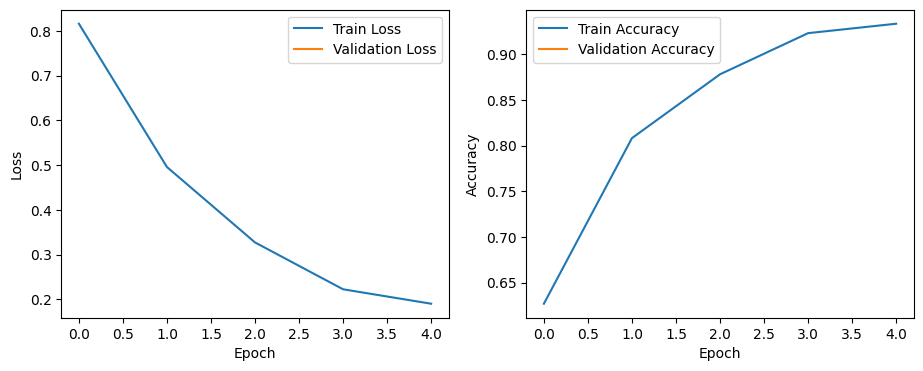

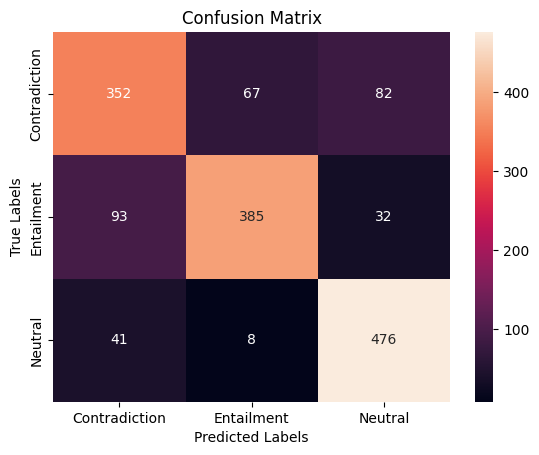

number_of_layers: 9


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.11.output.dense.bias', 'bert.encoder.layer.10.attention.self.value.weight', 'cls.seq_relationship.weight', 'bert.encoder.layer.9.output.dense.weight', 'bert.encoder.layer.9.attention.self.key.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.10.attention.self.query.weight', 'bert.encoder.layer.11.intermediate.dense.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.9.intermediate.dense.weight', 'bert.encoder.layer.11.output.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'bert.encoder.layer.9.output.dense.bias', 'cls.predictions.decoder.bias', 'bert.encode

Epoch 1/5


Train Loss: 0.8266 | Train Acc: 60.14%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.5348 | Train Acc: 78.46%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.3073 | Train Acc: 88.80%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.2328 | Train Acc: 91.56%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.2066 | Train Acc: 92.80%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 79.04
Test Precision: 78.78
Test Recall: 78.88
Test F1-score: 78.68
Confusion Matrix:
[[330 108  63]
 [ 58 427  25]
 [ 52  16 457]]


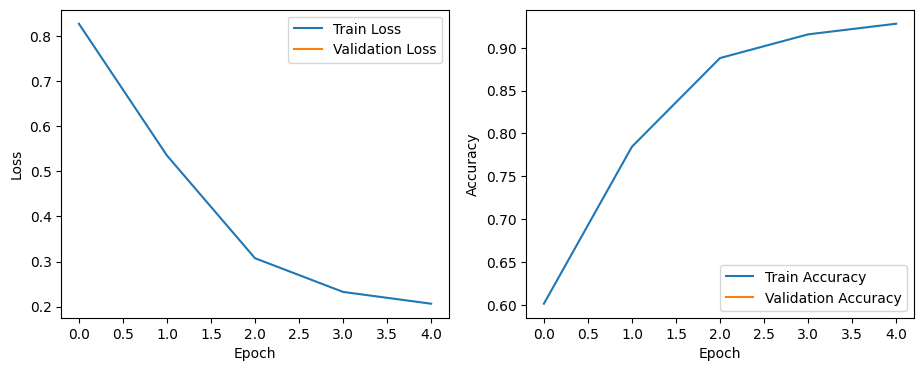

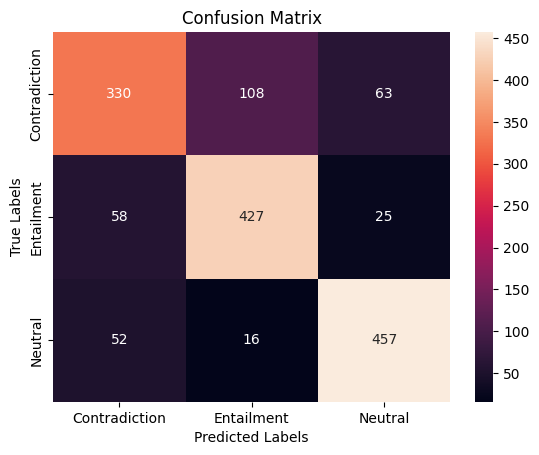

number_of_layers: 8


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.8.attention.output.dense.weight', 'bert.encoder.layer.11.output.dense.bias', 'bert.encoder.layer.10.attention.self.value.weight', 'cls.seq_relationship.weight', 'bert.encoder.layer.9.output.dense.weight', 'bert.encoder.layer.9.attention.self.key.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.encoder.layer.8.intermediate.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.10.attention.self.query.weight', 'bert.encoder.layer.11.intermediate.dense.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.9.intermediate.dense.weight

Epoch 1/5


Train Loss: 0.8335 | Train Acc: 60.20%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.5552 | Train Acc: 75.99%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.3534 | Train Acc: 86.77%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.2349 | Train Acc: 91.55%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.1764 | Train Acc: 93.71%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 78.58
Test Precision: 79.02
Test Recall: 78.53
Test F1-score: 78.65
Confusion Matrix:
[[385  72  44]
 [ 95 388  27]
 [ 80  11 434]]


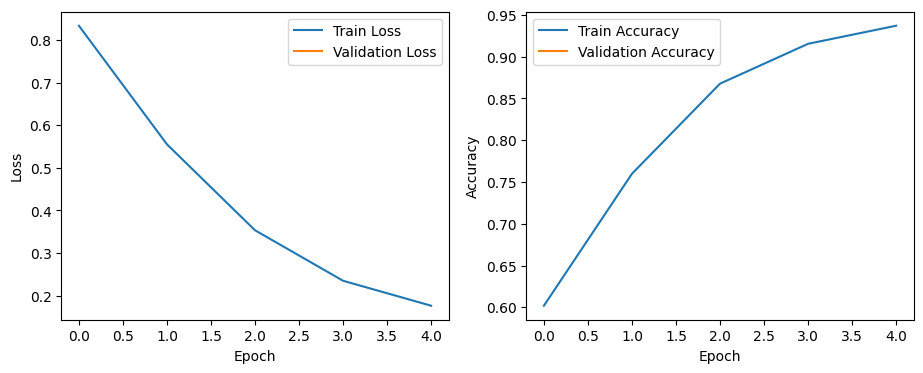

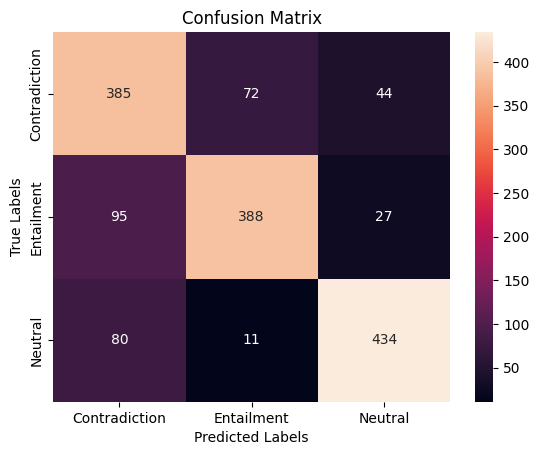

number_of_layers: 7


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.8.attention.self.query.weight', 'bert.encoder.layer.8.output.dense.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.7.attention.output.dense.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.bias', 'bert.encoder.layer.10.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.11.attention.self.key.weight', 'bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.8.attention.self.key.bias', 'bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.7.

Epoch 1/5


Train Loss: 0.8158 | Train Acc: 60.78%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.5348 | Train Acc: 78.33%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.3718 | Train Acc: 85.27%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.2554 | Train Acc: 91.21%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.2272 | Train Acc: 91.82%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 77.41
Test Precision: 77.13
Test Recall: 77.22
Test F1-score: 77.00
Confusion Matrix:
[[325  99  77]
 [ 70 396  44]
 [ 49   8 468]]


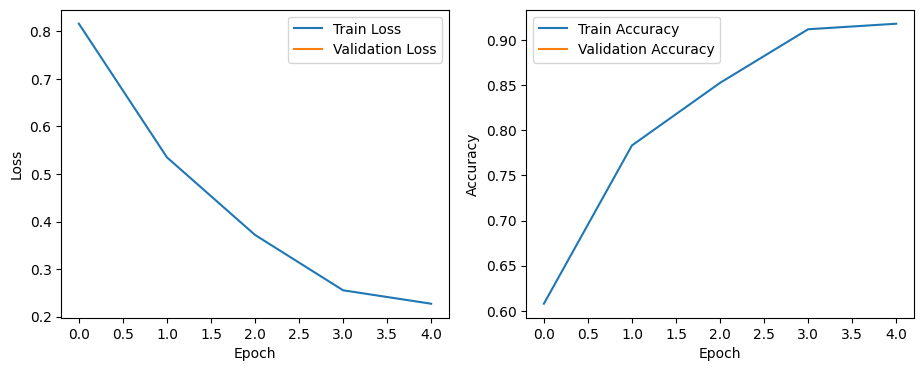

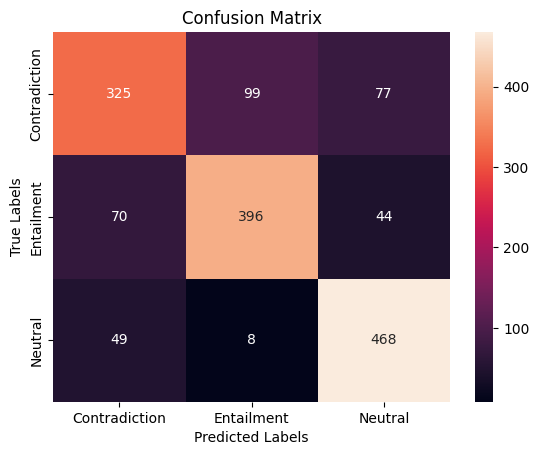

number_of_layers: 6


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.8.attention.self.query.weight', 'bert.encoder.layer.8.output.dense.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.7.attention.output.dense.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.bias', 'bert.encoder.layer.10.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.11.attention.self.key.weight', 'bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.6.intermediate.dense.weight', 'bert.encoder.l

Epoch 1/5


Train Loss: 0.8595 | Train Acc: 57.27%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.5964 | Train Acc: 73.14%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.3968 | Train Acc: 84.25%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.3670 | Train Acc: 86.02%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.2693 | Train Acc: 90.25%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 76.69
Test Precision: 77.97
Test Recall: 76.60
Test F1-score: 76.72
Confusion Matrix:
[[385  58  58]
 [153 340  17]
 [ 68   4 453]]


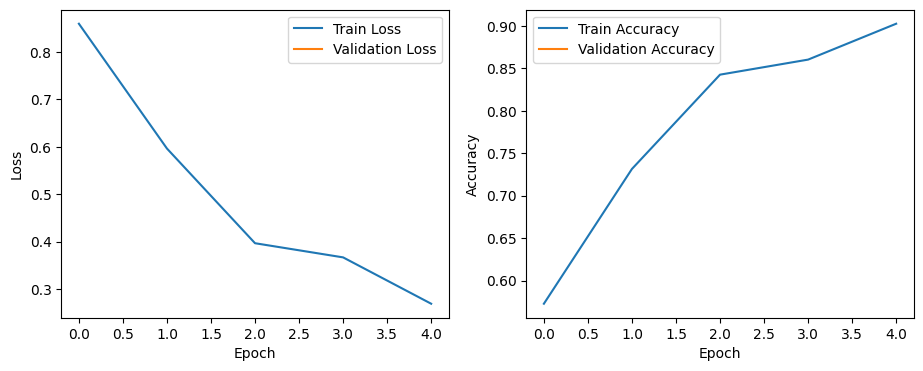

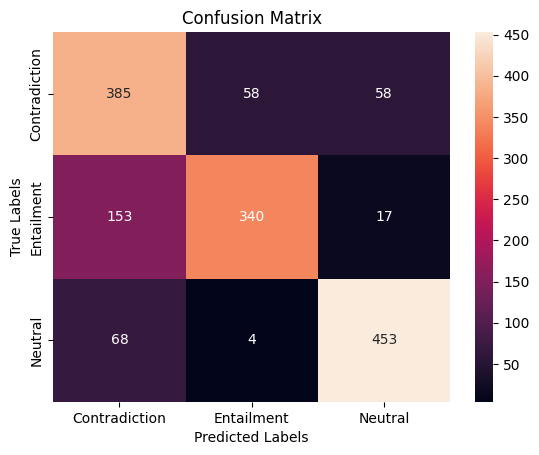

number_of_layers: 5


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'cls.predictions.decoder.weight', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.query.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.8.output.dense.weight', 'bert.encoder.layer.5.intermediate.dense.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.7.attention.output.dense.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.bias', 'bert.encoder.layer.10.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer

Epoch 1/5


Train Loss: 0.8915 | Train Acc: 55.97%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.5882 | Train Acc: 75.15%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.4012 | Train Acc: 84.43%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.2861 | Train Acc: 89.55%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.1959 | Train Acc: 93.21%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 77.08
Test Precision: 76.89
Test Recall: 76.87
Test F1-score: 76.44
Confusion Matrix:
[[296 136  69]
 [ 55 425  30]
 [ 45  17 463]]


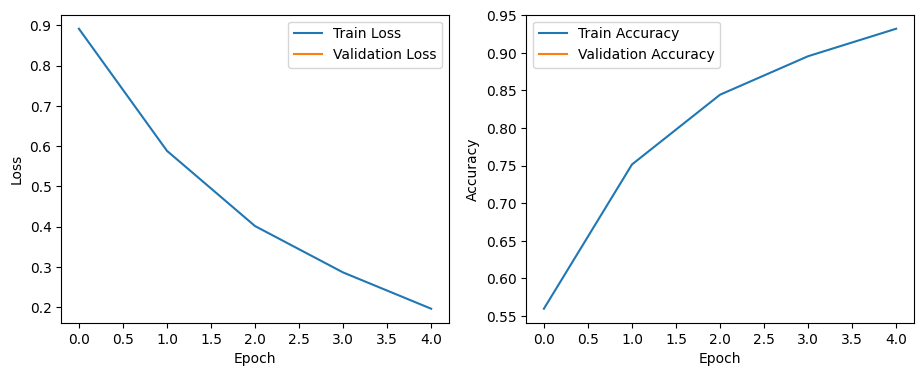

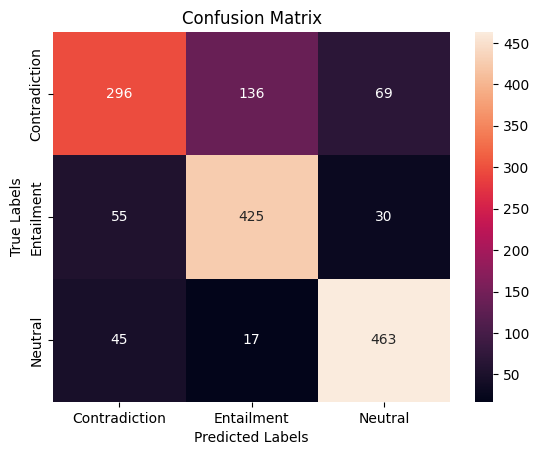

number_of_layers: 4


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.4.attention.output.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'cls.predictions.decoder.weight', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.query.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.8.output.dense.weight', 'bert.encoder.layer.5.intermediate.dense.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.7.attention.output.dense.weight', 'bert.encoder.layer.10.attention.output.dense.weight', 'bert.encoder.layer.10.attention.self.value.bias', 'bert.encoder.layer.4.attention.self.query.weight', 'bert.encoder.layer.1

Epoch 1/5


Train Loss: 0.9436 | Train Acc: 51.06%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 0.7341 | Train Acc: 64.48%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.5695 | Train Acc: 74.90%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.4021 | Train Acc: 83.23%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.3588 | Train Acc: 85.78%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 68.88
Test Precision: 71.06
Test Recall: 68.77
Test F1-score: 68.69
Confusion Matrix:
[[358  66  77]
 [201 271  38]
 [ 91   5 429]]


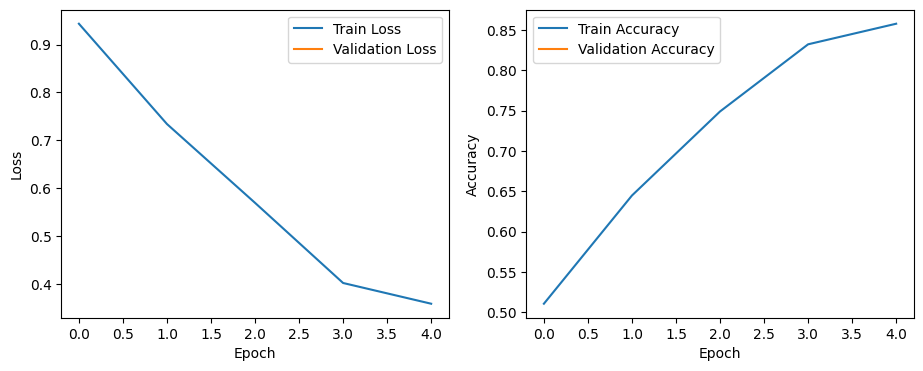

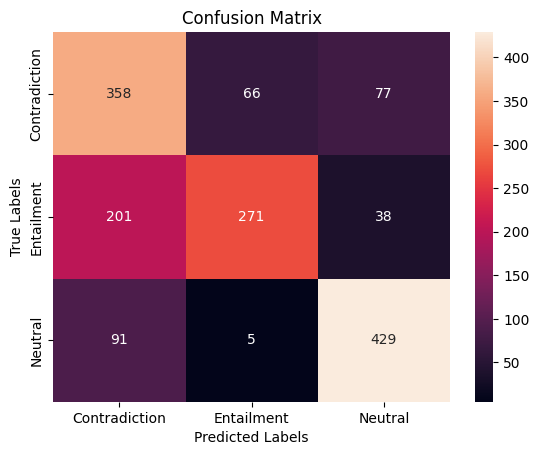

number_of_layers: 3


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.4.attention.output.dense.weight', 'bert.encoder.layer.3.attention.output.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.query.weight', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.8.output.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.5.intermediate.dense.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.7.attention.output.dense.weight', 'bert.encoder.layer.1

Epoch 1/5


Train Loss: 1.0983 | Train Acc: 35.90%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 1.0071 | Train Acc: 45.66%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.8056 | Train Acc: 58.11%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.7045 | Train Acc: 64.65%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.5414 | Train Acc: 73.49%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 51.17
Test Precision: 52.10
Test Recall: 51.14
Test F1-score: 51.34
Confusion Matrix:
[[260 142  99]
 [188 239  83]
 [166  72 287]]


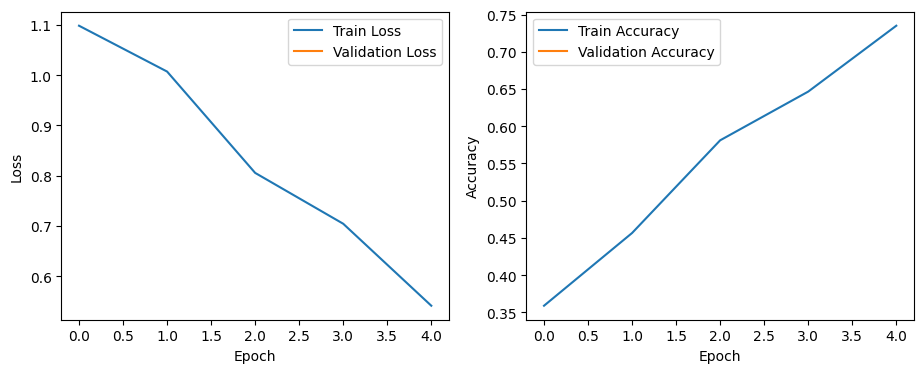

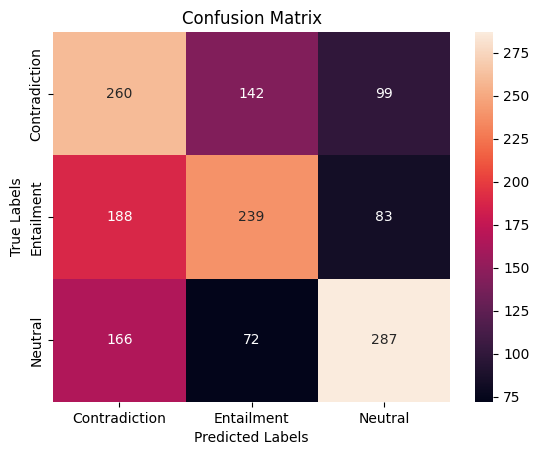

number_of_layers: 2


Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.4.attention.output.dense.weight', 'bert.encoder.layer.3.attention.output.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.query.weight', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.8.output.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.5.intermediate.dense.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.8.attention.self.value.weight', 'bert.encoder.layer.7.attention.output.dense.weight', 'bert.encoder.layer.1

Epoch 1/5


Train Loss: 1.1025 | Train Acc: 34.51%
Val Loss: nan | Val Acc: nan%
Epoch 2/5


Train Loss: 1.0575 | Train Acc: 42.59%
Val Loss: nan | Val Acc: nan%
Epoch 3/5


Train Loss: 0.9325 | Train Acc: 51.30%
Val Loss: nan | Val Acc: nan%
Epoch 4/5


Train Loss: 0.7594 | Train Acc: 59.81%
Val Loss: nan | Val Acc: nan%
Epoch 5/5


Train Loss: 0.6426 | Train Acc: 65.99%
Val Loss: nan | Val Acc: nan%


Test Accuracy: 40.89
Test Precision: 40.70
Test Recall: 40.47
Test F1-score: 37.91
Confusion Matrix:
[[105 141 255]
 [ 97 149 264]
 [ 44 107 374]]


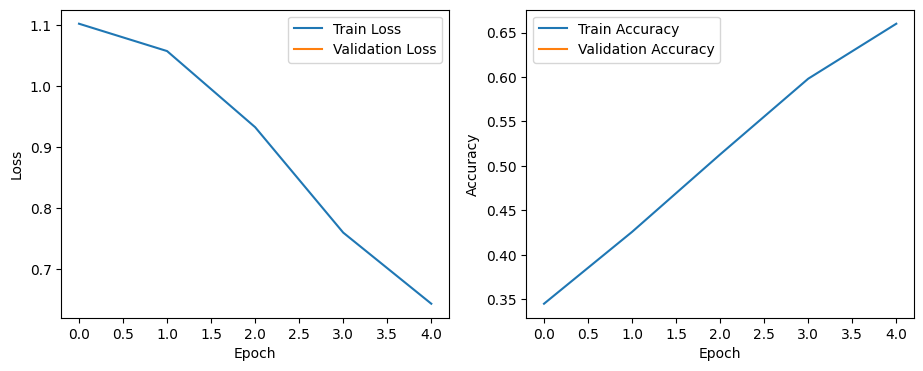

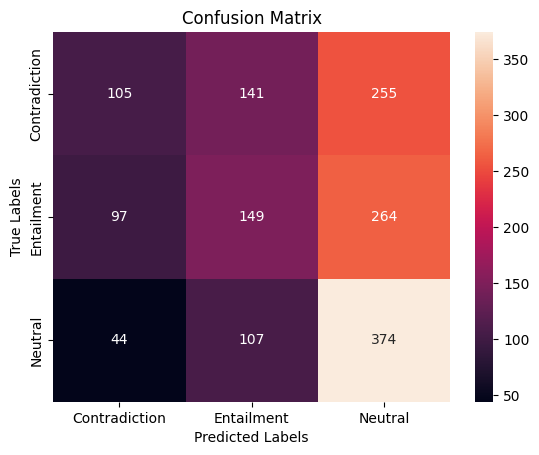

In [19]:
for n in range(1,11):

  # create model in each layer
    config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",num_hidden_layers= 12-n)
    print('number_of_layers:', config_layer.num_hidden_layers)
    model_name = Pars_BERT(config_layer)

  # finetune on that number of layers
    model_finetune = train_task3(5, train_dataloader, validation_dataloader,
                                     model_name, loss_fn,
                                     optim.Adam(model_name.parameters(),lr= 0.0001),
                                     str(12-n) + '_layer')
    

    # calculate statistics
    accuracy, precision, recall, f1, cm = model_eval(model_finetune, test_dataloader, str(12-n) + '_layer')
    accuracy_lst.append(accuracy)
    precision_lst.append(precision)
    recall_lst.append(recall)
    f1_lst.append(f1)
    cm_lst.append(cm)

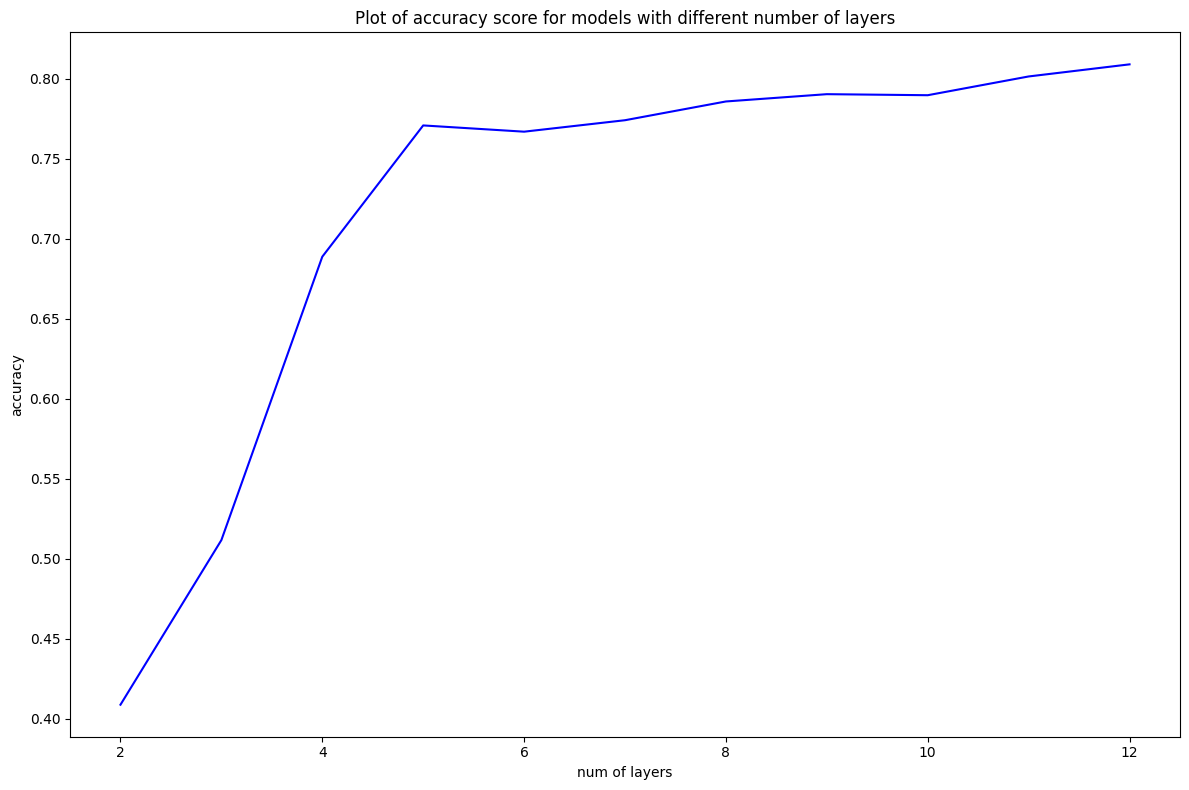

In [30]:
accuracy_lst_main = [0.809] + accuracy_lst


plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

x = accuracy_lst_main
y = np.arange(12, 1, -1)
plt.title("Plot of accuracy score for models with different number of layers")
plt.plot(y, x, color="blue")
plt.xlabel('num of layers')
plt.ylabel('accuracy') 

plt.show()

## **Part 4**

In [11]:
class Pars_BERT_Prune(nn.Module):
    def __init__(self, hidden_size, num_classes,config_layer,freeze,drop_heads):
        super(Pars_BERT_Prune, self).__init__()
        self.model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",config = config_layer)
        self.model=self.model.to(device)
        if freeze:
          for param in self.model.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.drop_heads = drop_heads

    def forward(self,input_ids,attention_mask,token_type_ids):
        self.model.prune_heads(self.drop_heads)
        _,o2= self.model(input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids, return_dict=False)
        o2 = self.fc1(o2)
        o2 = self.relu(o2)
        logits = self.fc2(o2)
        return logits

In [12]:
import random
def generate_dictionary(num_values, percent):
    random.seed(5)
    dictionary = {}
    num_chosen = int((percent / 100) * num_values)
    for key in range(0, 12):
        values = random.sample(range(num_values), num_chosen)
        dictionary[key] = values
    return dictionary

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4


Train Loss is : 0.873 | Train Accuracy is : 57.617%
Epoch 2/4


Train Loss is : 0.654 | Train Accuracy is : 71.847%
Epoch 3/4


Train Loss is : 0.468 | Train Accuracy is : 81.473%
Epoch 4/4


Train Loss is : 0.432 | Train Accuracy is : 82.310%


Test Accuracy: 77.93
Test Precision: 78.25
Test Recall: 77.81
Test F1-score: 77.62
Confusion Matrix:
[[318 142  41]
 [ 47 453  10]
 [ 75  24 426]]


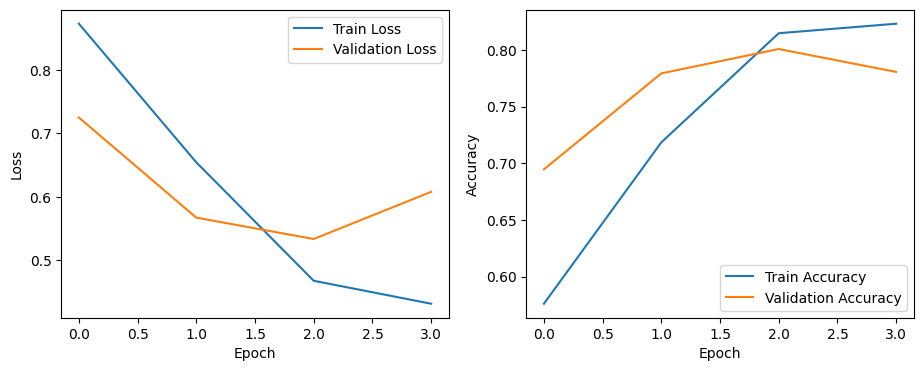

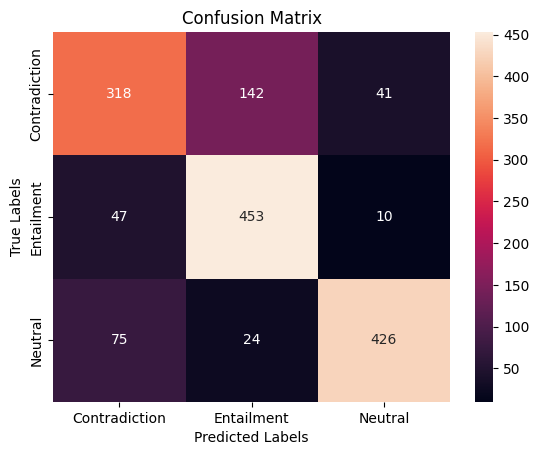

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4


Train Loss is : 0.917 | Train Accuracy is : 53.320%
Epoch 2/4


Train Loss is : 0.750 | Train Accuracy is : 63.686%
Epoch 3/4


Train Loss is : 0.654 | Train Accuracy is : 70.452%
Epoch 4/4


Train Loss is : 0.579 | Train Accuracy is : 74.316%


Test Accuracy: 79.10
Test Precision: 79.27
Test Recall: 79.02
Test F1-score: 79.07
Confusion Matrix:
[[355 107  39]
 [ 72 426  12]
 [ 80  11 434]]


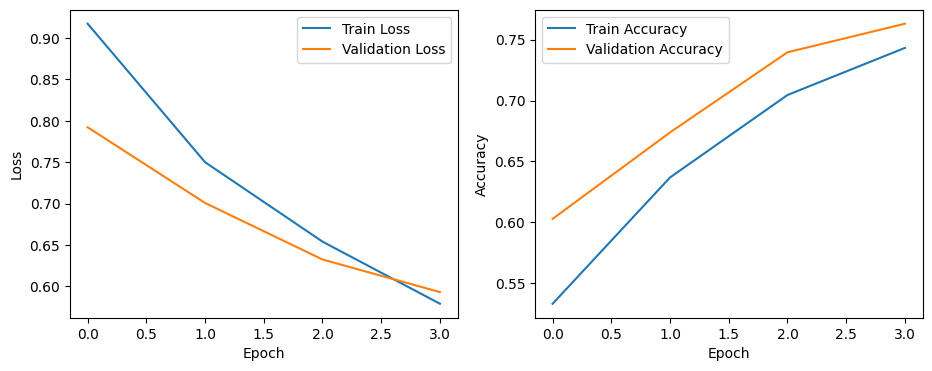

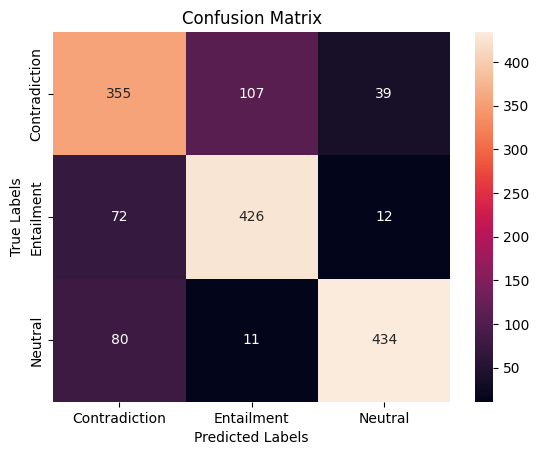

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/4


Train Loss is : 1.071 | Train Accuracy is : 40.499%
Epoch 2/4


Train Loss is : 0.996 | Train Accuracy is : 49.037%
Epoch 3/4


Train Loss is : 0.919 | Train Accuracy is : 53.111%
Epoch 4/4


Train Loss is : 0.831 | Train Accuracy is : 57.185%


Test Accuracy: 57.42
Test Precision: 58.16
Test Recall: 57.04
Test F1-score: 51.18
Confusion Matrix:
[[ 41 435  25]
 [  6 491  13]
 [ 64 111 350]]


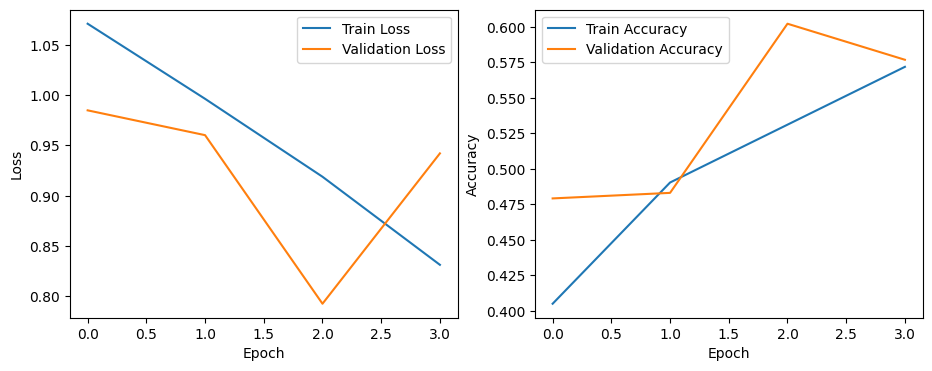

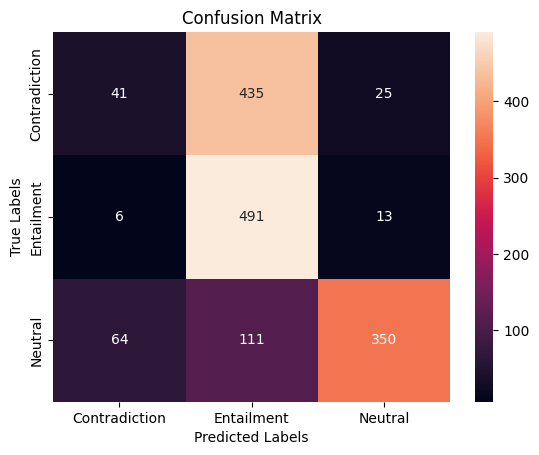

In [20]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
cm_lst = []
probabilities=[0.50,0.67,0.83]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models=[]
histories=[]
for p in probabilities:
  config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",attention_probs_dropout_prob=p)
  drop_heads = generate_dictionary(12,p)
  model_task3=Pars_BERT_Prune(768,3,config_layer,False,drop_heads)

  model=train(epochs = 4, dataloader = train_dataloader,
                valid_dataloader = validation_dataloader, model=model_task3,
                loss_fn = nn.CrossEntropyLoss(),
                optimizer = optim.Adam(model_task3.parameters(),lr= 0.0001), 
                name_plot = "Task3")
  
  # calculate statistics
  accuracy, precision, recall, f1, cm = model_eval(model, test_dataloader, str(p) + '_task4')
  accuracy_lst.append(accuracy)
  precision_lst.append(precision)
  recall_lst.append(recall)
  f1_lst.append(f1)
  cm_lst.append(cm)  


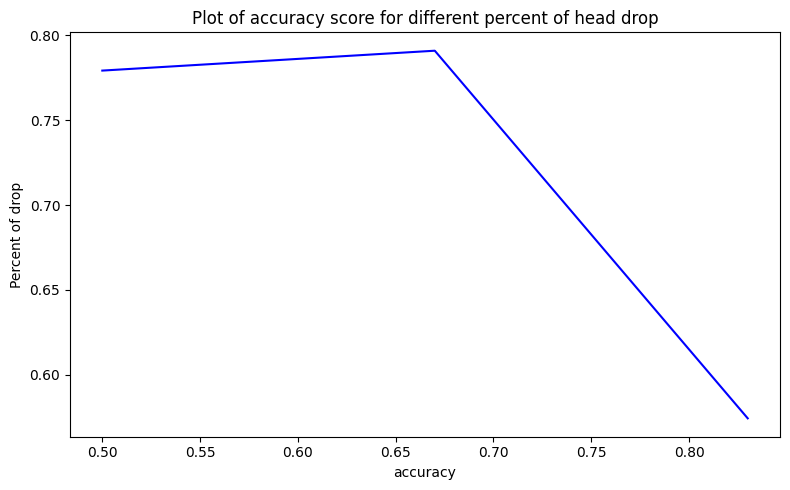

In [52]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True

x = accuracy_lst
y = [0.50,0.67,0.83]
plt.title("Plot of accuracy score for different percent of head drop")
plt.plot(y, x, color="blue")
plt.xlabel('accuracy')
plt.ylabel('Percent of drop') 

plt.show()

## **Part 5**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_layer = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model_task5=Pars_BERT(768,3,config_layer,False,drop_heads)

model=train(epochs = 4, dataloader = train_dataloader,
              valid_dataloader = validation_dataloader, model=model_task5,
              loss_fn = nn.CrossEntropyLoss(),
              optimizer = optim.Adam(model_task3.parameters(),lr= 0.0001), 
              name_plot = "Task5")

In [31]:
class ParsBert_Part5(Dataset):
    def __init__(self, tokenizer,max_length,address):
        super(ParsBert_Part5, self).__init__()
        self.train_csv=pd.read_csv(address, sep='\t')
        self.tokenizer=tokenizer
        self.train_csv['label'] = pd.Categorical(self.train_csv['label'])
        self.train_csv['label'] = self.train_csv['label'].cat.codes
        self.labels=self.train_csv['label']
        self.target=self.train_csv.iloc[:,2]
        self.max_length=max_length
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        text1 = self.train_csv.iloc[index,0]
        text2 = self.train_csv.iloc[index,1]
        inputs = self.tokenizer.encode_plus(
            text1 ,
            text2,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        input_ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        attention_mask = inputs["attention_mask"]
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.labels[index], dtype=torch.long)
            }

In [41]:
data = {
    'text1': ['پزشک خانم در بیمارستان است', 'او پسر  عالی باشد','او میرود'],
    'text2': ['پرستار اقا در بیمارستان است', 'او پسر عالی است', 'من رفتم'],
    'label': ['n', 'n','e']
}
# n=2 ,c=0,e=1
# Create DataFrame
df = pd.DataFrame(data)
df.to_csv('your_file_name.csv', sep='\t', index=False)
traindataset = ParsBert_Part5(tokenizer, max_length=100,address='your_file_name.csv')
trainloader =DataLoader(dataset=traindataset,batch_size=4)

In [42]:
all_predictions = []
all_targets = []
with torch.no_grad():
  loop_val = tqdm(enumerate(trainloader, 1),total=len(trainloader),
                  desc="val",position=0,leave=True,)
  for batch, dl in loop_val:
    input_ids=dl['input_ids']
    token_type_ids=dl['token_type_ids']
    attention_mask= dl['attention_mask']
    labels=dl['target']

    input_ids=input_ids.to(device)
    token_type_ids=token_type_ids.to(device)
    attention_mask=attention_mask.to(device)
    labels=labels.to(device)

    labels_pred=model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids)
    _, predicted = torch.max(labels_pred, 1)

    # Append predicted labels and true labels to the lists
    all_predictions.extend(predicted.tolist())
    all_targets.extend(labels.tolist())


val: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s]


In [43]:
print(all_predictions)

[0, 0, 1]


as it can be seen from above, the first two sentences are "CONTRADICTION" and the third one is "ENTAILMENT"